In [1]:
import sys
import platform
from os.path import join, exists, abspath
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'PcmPy')
sys.path.append(dname)
import PcmPy as pcm

In [9]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [10]:
list_sn = su.get_list_sn()

In [11]:
dir_atlas = su.get_dir_atlas()
Hem = ['L','R']
h = 'L'
exists(dir_atlas)

True

In [12]:
# list_roi = ['SMA', 'PMv', 'PMd', 'M1', 'S1', 'SPLa', 'SPLp', 'DSVC', 'MT+', 'VSVC', 'EAC']
list_roi = simage.get_list_roi()
list_roi

array(['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp'], dtype='<U4')

---

In [13]:
glm = 1

### GLM original

In [15]:
dir_glm = su.get_dir_glm(glm)

/var/folders/1b/hm3_g9y53yvgd0fwmdrv8q080000gp/T/ipykernel_63736/1018075743.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


S1 9.203e-03(**)
M1 1.295e-02(*)
PMd 3.404e-03(**)
PMv 9.238e-03(**)
SMA 8.167e-03(**)
V1 9.377e-06(****)
SPLa 2.981e-03(**)
SPLp 6.716e-04(***)


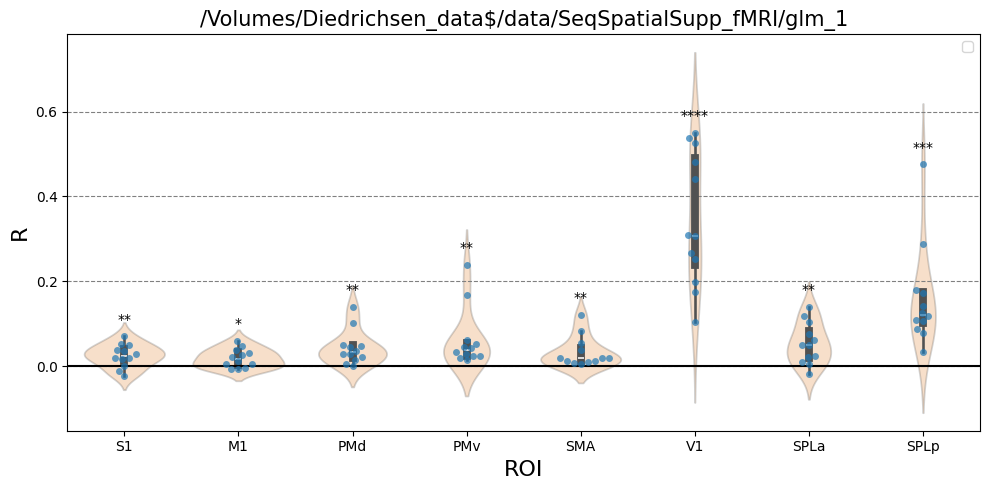

### GLMsingle

In [14]:
dir_glm = ssingle.get_dir_glmsingle(glm)

load beta

In [15]:
result = {'subj':[], 'roi':[], 'r':[], 'r_corr':[]}
for rr, roi in enumerate(list_roi):
    print(roi)
    Y = []
    for ss, sn in enumerate(tqdm(list_sn)):
        subj = 'S'+sn
        fname = join(dir_glm,'beta.%s.%s.%drois.npz'%(h,subj,len(list_roi)))
        with np.load(fname, allow_pickle=True) as npz:
            dataset = npz['dataset']
            cond_vec = npz['cond_vec']
            part_vec = npz['part_vec']
            
        obs_des = {'cond_vec': cond_vec, 'part_vec':part_vec}
        Y.append(
            pcm.dataset.Dataset(
                measurements=dataset[rr][:len(cond_vec),:],
                obs_descriptors=obs_des
            )
        )

    for ss, sn in enumerate(list_sn):
        subj = 'S'+sn
        data = Y[ss].measurements
        cond_vec = Y[ss].obs_descriptors['cond_vec']
        part_vec = Y[ss].obs_descriptors['part_vec']
        r_corr = np.mean(
            rel.within_subj_loo(data, cond_vec, part_vec, separate='none', subtract_mean=True)
        )
        r = rel.within_subj(data, cond_vec, part_vec, separate='none', subtract_mean=True)[0]
        result['subj'].append(subj)
        result['roi'].append(roi)
        result['r'].append(r)
        result['r_corr'].append(r_corr)

df = pd.DataFrame(result)
del result

S1


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 21.32it/s]


M1


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.08it/s]


PMd


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.57it/s]


PMv


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.37it/s]


SMA


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.33it/s]


V1


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 22.07it/s]


SPLa


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 24.87it/s]


SPLp


100%|██████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.15it/s]


/var/folders/1b/hm3_g9y53yvgd0fwmdrv8q080000gp/T/ipykernel_73940/1018075743.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


S1 4.527e-03(**)
M1 7.552e-04(***)
PMd 7.609e-04(***)
PMv 1.857e-03(**)
SMA 6.047e-03(**)
V1 1.779e-05(****)
SPLa 2.948e-05(****)
SPLp 1.011e-03(**)


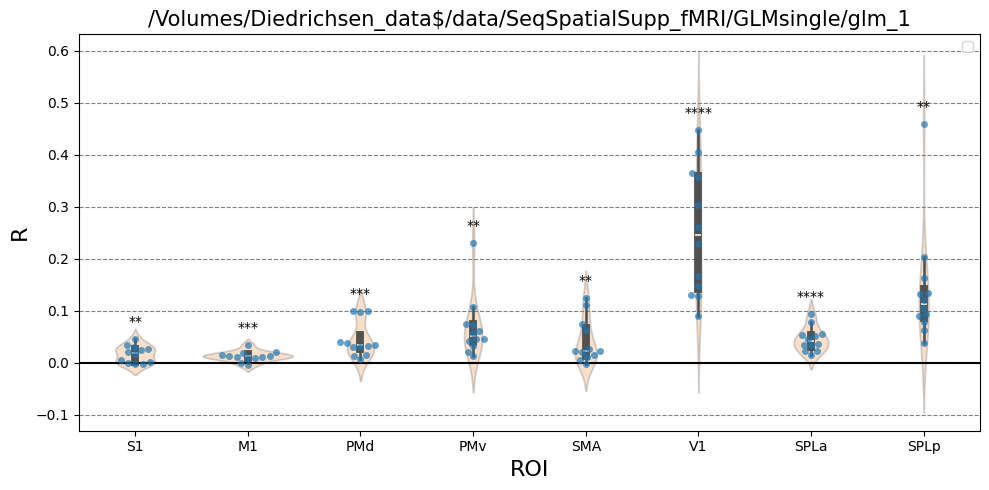

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

x = 'roi'
y = 'r'
sns.swarmplot(
    data=df,
    x=x, y=y,
    alpha=0.7,
    ax=ax
)
sns.violinplot(
    data=df,
    x=x, y=y,
    alpha=0.25,
    ax=ax
)
ax.grid(axis='y', linestyle='--', color='gray')
ax.legend()
ax.axhline(y=0, color='black')
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=40, ha='right')
ax.set_xlabel(x.upper(), fontsize=16)
ax.set_ylabel(y.upper(), fontsize=16)
ax.set_title('%s'%dir_glm, fontsize=15)

dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    a = df[df.roi==roi][y].astype(float)
    tval, pval = scipy.stats.ttest_1samp(a, popmean=0)
    if pval < 0.05:
        print(roi, '%.3e(%s)'%(pval,su.convert_pval_to_star(pval)))
        ax.text(
            x=ii, y=a.max() + dy,
            s=su.convert_pval_to_star(pval), fontsize=10,
            ha='center', va='bottom'
        )
fig.tight_layout()

---

## Pre-whitening

OLS: $\underset{K \times P}{\hat{\beta}} = \underset{K \times T}{X}^{+}\underset{T \times P}{Y} = (\underset{K \times T}{X}^{T}\underset{T \times K}{X})^{-1}\underset{K \times T}{X}^{T}\underset{T \times P}{Y}$

$\rightarrow$ (spatial) variance-covariance matrix: $\underset{P \times P}{\Sigma} = \frac{1}{T}\underset{P \times T}{\epsilon}^{T}\underset{T \times P}{\epsilon}$

where $\epsilon = Y - X\hat{\beta}$

### (spatial) Pre-whitening

$$
\tilde{\beta} = \underset{K \times P}{\beta}\underset{P \times P}{\Sigma}^{-\frac{1}{2}}
$$

- Multi-variate pre-whitening:
  $\Sigma_{ij}^{-\frac{1}{2}}=Cov(\epsilon_{i},\epsilon_{j})=\frac{1}{T}\underset{1 \times T}{\epsilon_{i}}^{T}\underset{T \times 1}{\epsilon_{j}}$

- Uni-variate pre-whitening:
  $\Sigma_{ij}^{-\frac{1}{2}}=Cov(\epsilon_{i},\epsilon_{j})=\frac{1}{T}\underset{1 \times T}{\epsilon_{i}}^{T}\underset{T \times 1}{\epsilon_{j}}\textcolor{red}{\delta_{ij}}$
  $$
  \Sigma^{-\frac{1}{2}} = \begin{bmatrix}
\frac{1}{\sigma_{1}} & \textcolor{gray}{0} & \cdots & \textcolor{gray}{0} \\
\textcolor{gray}{0} & \frac{1}{\sigma_{2}} & \cdots & \textcolor{gray}{0} \\
\vdots & \vdots & \ddots & \vdots \\
\textcolor{gray}{0} & \cdots & \textcolor{gray}{0} & \frac{1}{\sigma_{P}} \\
\end{bmatrix}
  $$ = (`ResMS.nii`)$^{-\frac{1}{2}}$

In [13]:
subj = 'S01'

In [14]:
beta_whiten = simage.get_prewhitened_beta(subj=subj, glm=glm)
beta_whiten.shape

(64, 32492)

<Axes: >

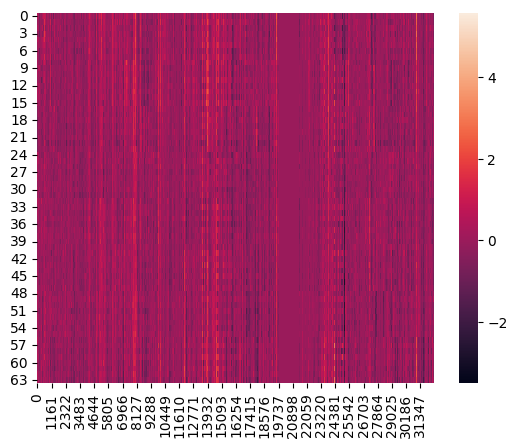

In [17]:
sns.heatmap(beta_whiten)

In [15]:
reginfo = deal_spm.load_reginfo(subj=subj, dir_glm=dir_glm)
reginfo

,sn,run,cond,regIdx,seq,cue,reg
0,1,1,1,1,1,L,"(1,L)"
1,1,1,2,2,1,S,"(1,S)"
2,1,1,3,3,2,L,"(2,L)"
3,1,1,4,4,2,S,"(2,S)"
4,1,1,5,5,3,L,"(3,L)"
...,...,...,...,...,...,...,...
59,1,8,4,60,2,S,"(2,S)"
60,1,8,5,61,3,L,"(3,L)"
61,1,8,6,62,3,S,"(3,S)"
62,1,8,7,63,4,L,"(4,L)"


---

## Reliability Estimation

As a measure of functional signal-to-noise ratio, we can calculate the reliability of activity patterns across runs. The measured activity pattern from subject $i$ in run $j$ ($y_{i,j}$) can be thought of consisting of the signal in subject $i$ ($s_i$) and measurement noise $\epsilon_{i,j}$.
$$
y_{i,j}=s_{i}+\epsilon_{i,j}
$$

For each subject, we can calculate the variances (or second moments) of these patterns across voxels and / or conditions:
$$
v_{s}=s_{i}^{T}s_{i}
$$
$$
v_{\epsilon}=E(\epsilon^{T}\epsilon)
$$

The correlation of the measured activity patterns across runs then is:
$$
r_{run}=\frac{v_{s}}{v_{s}+v_{\epsilon}}
$$

This reliability measure is the reliability of one measurement (run). The (theoretical) reliability of the mean activity pattern (across $N$ measurement runs) then would be:
$$
r_{whole}=\frac{v_{s}}{v_{s}+v_{\epsilon}/N}
$$

With a bit of algebra, you can calculate the theoretical reliability of the mean activity pattern from the reliability across runs:
$$
r_{whole}=\frac{r_{run}N}{r_{run}(N-1)+1}
$$

cf)
$$
r_{whole}=\frac{v_{s}}{v_{s}+v_{\epsilon}/N}=\frac{v_{s}N}{v_{s}N+v_{\epsilon}}=\frac{\frac{v_{s}}{v_{s}+v_{\epsilon}}N}{\frac{v_{s}}{v_{s}+v_{\epsilon}}N+\frac{v_{\epsilon}}{v_{s}+v_{\epsilon}}}=\frac{r_{run}N}{r_{run}N+1-r_{run}}
$$

This is the *Spearman-brown prediction formula*

In [18]:
beta_whiten = np.ones((len(list_sn),len(reginfo),32492)) * np.nan
# for ss in ['S','R']:
for ss in ['S']:
    for jj, nn in enumerate(list_sn):
        subj = ss+nn
        beta_whiten[jj] = simage.get_prewhitened_beta(subj=subj, glm=glm)

In [19]:
## We can quickly calculate the reltiability of the data within each subjects across different runs:
rw = rel.within_subj(
    data=beta_whiten,
    cond_vec=reginfo.cond, part_vec=reginfo.run,
    separate='none', subtract_mean=True
)

## rw will be a vector of reliability values for each subject, if multiple subjects are present.
print(rw)

[[0.24143811]
 [0.06011706]
 [0.11180517]
 [0.1230022 ]
 [0.05689732]
 [0.03279897]
 [0.06451726]
 [0.08217396]
 [0.0603014 ]
 [0.09735093]
 [0.1404986 ]
 [0.05289119]]


In [20]:
var = rel.decompose_subj_group(
    data=beta_whiten,
    cond_vec=reginfo.cond, part_vec=reginfo.run,
    separate='subject_wise', subtract_mean=True
)

print(var)

[[0.00203588 0.01014126 0.03825874]
 [0.00084654 0.00340382 0.06645111]
 [0.00177362 0.00405473 0.04630122]
 [0.00210282 0.01245635 0.10380598]
 [0.00111666 0.00227373 0.05619741]
 [0.00146786 0.00106242 0.07461481]
 [0.0009566  0.00434719 0.07690351]
 [0.00099465 0.0062147  0.08052336]
 [0.00124469 0.00375728 0.07794759]
 [0.00142239 0.00358096 0.04639159]
 [0.00187059 0.00765127 0.05825006]
 [0.00132552 0.00327487 0.08237805]]


---

In [32]:
# %whos